In [1]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
import h5py
import numpy as np

import matplotlib.pyplot as plt
from cooltools.lib.numutils import set_diag
from scipy.stats import spearmanr

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_co

In [2]:
# import tensorrt as trt (if installed, it's not used by Akita anyways)
import tensorflow as tf
from basenji import seqnn, stream, dataset, dna_io

2024-04-22 13:56:14.662498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 13:56:14.662572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 13:56:14.693963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 13:56:14.788741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 13:56:17.567392: W tensorflow/compiler/tf2

In [3]:
from akita_utils.utils import ut_dense
from akita_utils.dna_utils import dna_1hot

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


## Cropping functions

In [5]:
def crop_center(matrix, new_height=448, new_width=448):
    """
    Crop the central part of a matrix to a specified size.
    
    Parameters:
    - matrix: Input 2D numpy array of shape (height, width).
    - new_height: Height of the cropped matrix.
    - new_width: Width of the cropped matrix.
    
    Returns:
    - Cropped 2D numpy array of shape (new_height, new_width).
    """
    # Calculate the starting points for cropping
    start_x = (matrix.shape[1] - new_width) // 2
    start_y = (matrix.shape[0] - new_height) // 2
    
    # Perform the cropping
    cropped_matrix = matrix[start_y:start_y+new_height, start_x:start_x+new_width]
    
    return cropped_matrix


def matrix_to_upper_triangular_vector_excluding_diagonals(matrix, diagonals_to_exclude=2):
    """
    Convert a square matrix to a vector containing only the upper triangular part,
    excluding a specified number of diagonals from the start.
    
    Parameters:
    - matrix: 2D numpy array of shape (N, N)
    - diagonals_to_exclude: Number of diagonals to exclude from the start (default is 2)
    
    Returns:
    - Vector containing the upper triangular part of the matrix, excluding the specified diagonals.
    """
    # Use np.triu_indices to get the indices of the upper triangular part, excluding specified diagonals
    upper_tri_indices = np.triu_indices(matrix.shape[0], diagonals_to_exclude)
    
    # Extract the upper triangular part of the matrix using the indices
    upper_tri_vector = matrix[upper_tri_indices]
    
    return upper_tri_vector


def crop_and_vectorize(vector_prediction):
    maps = ut_dense(vector_prediction[0,:,:])
    cropped_maps = np.array([crop_center(maps[:,:,target_index]) for target_index in range(maps.shape[2])])
    cropped_maps = np.transpose(cropped_maps, (1, 2, 0))
    vectorized = np.array([matrix_to_upper_triangular_vector_excluding_diagonals(cropped_maps[:,:,target_index]) for target_index in range(maps.shape[2])])
    return np.transpose(vectorized, (1, 0))


In [6]:
### names of targets ###

human_dir = "/project/fudenber_735/tensorflow_models/akita/v2/data/hg38/"

hic_targets = pd.read_csv(human_dir+'/targets.txt',sep='\t')
hic_file_dict_num = dict(zip(hic_targets['index'].values, hic_targets['file'].values) )
hic_file_dict = dict(zip(hic_targets['identifier'].values, hic_targets['file'].values) )
hic_num_to_name_dict = dict(zip(hic_targets['index'].values, hic_targets['identifier'].values) )

# read data parameters
data_stats_file = '%s/statistics.json' % human_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

## Reading test dataframe and loading targets

In [7]:
v1_data_split_path = "/project/fudenber_735/tensorflow_models/akita/v1/data/sequences.bed"

In [8]:
all_test_V1_seqs = pd.read_csv(v1_data_split_path, sep='\t', names=['chr','start','stop','type'])
all_test_V1_seqs = all_test_V1_seqs.iloc[all_test_V1_seqs['type'].values=='test']

In [10]:
overlap_test = pd.read_csv("./data/v1_v2_sequences.tsv", sep='\t')

In [11]:
num_models = overlap_test.type_v2.nunique()

In [12]:
overlap_test["model"] = overlap_test.apply(lambda x: int(str(x.type_v2)[-1]), axis=1)

In [13]:
# reading inputs and targets
data_dir_v1 = "/project/fudenber_735/tensorflow_models/akita/v1/data/"
test_data_v1 = dataset.SeqDataset(data_dir_v1, 'test', batch_size=8)
test_inputs, test_targets = test_data_v1.numpy(return_inputs=True, return_outputs=True)

In [14]:
# calculate the difference in windows' sizes
v1_seq_length = len(test_inputs[0])
v2_seq_length = 1310720
to_expand = (v2_seq_length - v1_seq_length) // 2

## General models parameters

In [15]:
# model's parameters
batch_size=8 
head_index = 0 # human!
shifts = "0"
rc = False

In [16]:
shifts = [int(shift) for shift in shifts.split(",")]

In [17]:
models_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models"

## iterating over models

In [18]:
genome_fasta = "/project/fudenber_735/genomes/hg38/hg38.fa"

# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [ ]:
# from akita_utils.stats_utils import plot_map

In [19]:
all_cropped_preds = []
all_targets = []
all_dataframes = []

for model_index in range(num_models):
# for model_index in range(1):

    fold_sequences = overlap_test[overlap_test["model"] == model_index]
    
    test_MSE = []
    test_Spearman = []
    
    params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
    model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

    # read model parameters
    with open(params_file) as params_open:
        params = json.load(params_open)
    params_train = params["train"]
    params_model = params["model"]
    
    if batch_size is None:
        batch_size = params_train["batch_size"]
    else:
        batch_size = batch_size

    # load model
    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, head_i=head_index)
    seqnn_model.build_ensemble(rc, shifts)
    seq_length = int(params_model["seq_length"])

    print("MODEL: ", model_index)
    print("Number of sequences: ", len(fold_sequences))

    for ind, row in fold_sequences.iterrows():
        chr, seq_start, seq_end = row.chr, row.start, row.stop
        myseq_str = chr+':'+str(seq_start)+'-'+str(seq_end)
        print("\t - ", myseq_str)
        v2_seq_start, v2_seq_end = row.start - to_expand, row.stop + to_expand
        
        # fetching
        seq_1hot = dna_1hot(
                genome_open.fetch(
                    chr, v2_seq_start, v2_seq_end
                ).upper()
            )
        expanded_seq_1hot = np.expand_dims(seq_1hot, 0)
        
        index = np.where((all_test_V1_seqs['chr'].values== chr) *
                             (all_test_V1_seqs['start'].values== int(seq_start))*
                             (all_test_V1_seqs['stop'].values==  int(seq_end)))[0][0]    
        
        test_target = test_targets[index:index+1,:,:]
        test_target = np.squeeze(test_target, axis=0)
        test_pred = seqnn_model.model.predict(expanded_seq_1hot)
        cropped_pred = crop_and_vectorize(test_pred)

        # print("test_target", test_target.shape)
        # print("cropped_pred", cropped_pred.shape)

        # test_target_maps = ut_dense(test_target)
        # test_pred_maps = ut_dense(cropped_pred)
    
        # print("target: ")
        # plot_map(test_target_maps[:,:,0])
        # print("prediction: ")
        # plot_map(test_pred_maps[:,:,0])

        all_targets.append(test_target)
        all_cropped_preds.append(cropped_pred)
        
        MSE = [np.mean((test_target[:,target_index] - cropped_pred[:,target_index]) ** 2) for target_index in range(test_pred.shape[2])]
        test_MSE.append(MSE)
    
        spearman = [spearmanr(cropped_pred[:,target_index], test_target[:,target_index])[0] for target_index in range(test_pred.shape[2])]
        test_Spearman.append(spearman)

    test_MSE_array = np.array(test_MSE)
    test_Spearman_array = np.array(test_Spearman)

    fold_sequences = fold_sequences.copy()
    
    for target_index in range(5):
        fold_sequences.loc[:, f"v2_MSE_{target_index}"] = test_MSE_array[:, target_index]
        fold_sequences.loc[:, f"v2_S_{target_index}"] = test_Spearman_array[:, target_index]
    
    # Now perform your operation
    fold_sequences.loc[:, 'v2_MSE'] = fold_sequences[[f"v2_MSE_{target_index}" for target_index in range(5)]].mean(axis=1)
    fold_sequences.loc[:, 'v2_S'] = fold_sequences[[f"v2_S_{target_index}" for target_index in range(5)]].mean(axis=1)

    all_dataframes.append(fold_sequences)

print("DONE")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

## Collecting Results

In [20]:
result = pd.concat(all_dataframes)

In [21]:
# result.to_csv("v2_results.tsv", sep="\t", index=False, header=True)

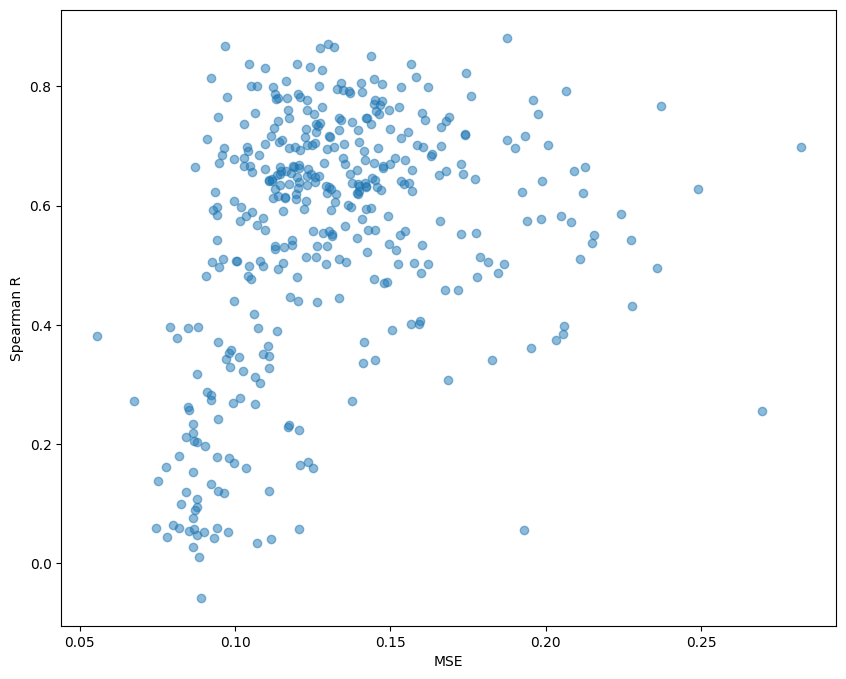

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(result["v2_MSE"], result["v2_S"], alpha=0.5)

ax.set_xlabel("MSE")
ax.set_ylabel("Spearman R")

# ax.set_title(f"Correlation between boundary SCD and dot SCD; Pearson Correlation = {rounded_pearson_corr}")

# plt.savefig("./plots/boundarySCD_vs_dotSCD.png", bbox_inches="tight")

plt.show()

In [23]:
all_cropped_preds = np.array(all_cropped_preds)
all_targets = np.array(all_targets)

In [24]:
from scipy.stats import spearmanr, pearsonr

In [25]:
pearR = pearsonr(all_cropped_preds.flatten(), all_targets.flatten())

In [26]:
pearR

PearsonRResult(statistic=0.6550893010111157, pvalue=0.0)

In [27]:
spearmanR = spearmanr(all_cropped_preds.flatten(), all_targets.flatten())

In [28]:
spearmanR

SignificanceResult(statistic=0.5941143091002724, pvalue=0.0)

In [31]:
mse = ((all_targets.flatten() - all_cropped_preds.flatten()) ** 2).mean()

In [32]:
mse

0.13087174